# Neural Network Model Optimization and Training

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# set seeds for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

In [2]:
# load the data
X_train = pd.read_csv("../../Data/X_train.csv")
y_train = pd.read_csv("../../Data/y_train.csv")

print(f"Training Data Shape:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print(f"\nFirst few rows of X_train:")
X_train.head()

Training Data Shape:
X_train: (400, 9)
y_train: (400, 1)

First few rows of X_train:


,User_ID,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform
0,U297,23,Female,5.0,5.0,7.0,2.0,4.0,Instagram
1,U221,23,Other,5.2,7.0,6.0,5.0,1.0,YouTube
2,U001,44,Male,3.1,7.0,6.0,2.0,5.0,Facebook
3,U256,33,Female,5.9,4.0,7.0,0.0,3.0,LinkedIn
4,U336,27,Male,3.8,8.0,6.0,6.0,4.0,Facebook


### Data Preprocessing
Code chunk consists of two helper methods, encode_scale and prepare_tensors, to be used for the preprocessing steps of each fold of the cross-validation loop. Doing this step inside each loop prevents data leakage among the different folds.


encode_scale
- utilizes LabelEncoder() to encode the categorical variables in X_train (gender, social media platform)
- drops categorical UserID field
- uses StandardScaler() to standardize data

prepare_tensors
- converts the train and validation sets into PyTorch tensors
- utilizes DataLoader() and TrainDataset() to load and format the tensors for batch processing



In [3]:
def encode_scale(X_train, X_val, categorical_features):
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy()

    # use label encoder to encode applicable categorical variables
    for feature in categorical_features:
        if feature != 'User_ID':
            le = LabelEncoder()
            X_train_processed[feature] = le.fit_transform(X_train[feature])
            X_val_processed[feature] = le.transform(X_val[feature])
        else:
            # drop user id column
            X_train_processed = X_train_processed.drop('User_ID', axis=1)
            X_val_processed = X_val_processed.drop('User_ID', axis=1)
    
    # scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_processed)
    X_val_scaled = scaler.transform(X_val_processed)
    
    return X_train_scaled, X_val_scaled


def prepare_tensors(X_train, y_train, X_val, y_val, batch_size):

    # convert train and validation sets into tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1,1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).reshape(-1,1)

    # load tensors for batch processing 
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
                        batch_size = batch_size,
                        shuffle = True
    )

    return train_loader, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor

### Model Setup

Creating Neural Network class in order to instantiate a NeuralNet() object in our cross-validation folds. Neural network has three linear layers and two layers of ReLU activation function, and two layers of dropout to prevent overfitting. It utilizes module_list to iterate through each layer in the forward() function.

In [4]:
# define neural network model

class NeuralNet(nn.Module):

    def __init__(self, input_dim=8, hidden_dim=16, dropout=0.0):
        super().__init__()
        l1 = nn.Linear(input_dim, hidden_dim)
        a1 = nn.ReLU()
        d1 = nn.Dropout(dropout)
        l2 = nn.Linear(hidden_dim, hidden_dim)
        a2 = nn.ReLU()
        d2 = nn.Dropout(dropout)
        l3 = nn.Linear(hidden_dim,1)
        l = [l1, a1, d1, l2, a2, d2, l3]
        self.module_list = nn.ModuleList(l)

    def forward(self, X):
        for f in self.module_list:
          X = f(X)
        return X

Defining the parameter grid to cycle through for optimization. Parameter grid consists of four different variables (hidden dimensions, dropout, learning rate, batch size, number of epochs), creating a total of 48 possible combinations of parameters.

In [5]:
# set hyperparameter grid

param_grid = {
    "hidden_dim": [16, 32, 64],
    "dropout": [0.0, 0.2],
    "lr": [0.001, 0.01],
    "batch_size": [16, 32],
    "n_epochs": [100, 300]
}

### Model Training and Optimization

Utilizing KFold with 5 splits and a manually implemented cross-validation loop to find the best performing parameters. Tuning the number of hidden dimensions, dropout, learning rate, batch size, and number of epochs. Using MSE Loss as our cost function, and Adam as our optimizer with weighted decay. Storing the parameters, average MSE/R² score, and a manually computed "combined score" for each unique set of parameters in an array to be accessed later.

In [6]:
# cross-validation and parameter tuning

k = 5
kf = KFold(n_splits = k, shuffle=True, random_state=1234)

results = []

# to print progress (loop {loop} out of {total loops})
loop = 0
total_loops = math.prod(len(v) for v in param_grid.values())

# nested for loop to test every parameter combination
for hidden_dim in param_grid["hidden_dim"]:
    for dropout in param_grid["dropout"]:
        for lr in param_grid["lr"]:
            for batch_size in param_grid["batch_size"]:
                for n_epochs in param_grid["n_epochs"]:
                    fold_mse = []
                    fold_rmse = []
                    fold_mae = []
                    fold_r2 = []
                    
                    loop += 1

                    print(f"\n--- Initializing Validation Loop {loop}/{total_loops}. Params: hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}, batch_size={batch_size}, n_epochs={n_epochs} ---\n")
                    
                    # to calculate y_true and y_pred for the full fold
                    all_val_true = []
                    all_val_pred = []
                    
                    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
                        
                        # create, encode, standardize, and load/format train and validation sets for batch processing
                        X_train_fold, X_val_fold = X_train.iloc[train_index].copy(), X_train.iloc[val_index].copy()
                        y_train_fold, y_val_fold = y_train.iloc[train_index].copy(), y_train.iloc[val_index].copy()

                        categorical_features = X_train_fold.select_dtypes(include=['object']).columns.tolist()
                        X_train_processed, X_val_processed = encode_scale(X_train_fold, X_val_fold, categorical_features)
                        
                        train_loader, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = prepare_tensors(X_train_processed, y_train_fold, X_val_processed, y_val_fold, batch_size)

                        # train model and find best params
                        model = NeuralNet(input_dim=X_train_processed.shape[1], hidden_dim=hidden_dim, dropout=dropout)
                        cost_function = nn.MSELoss()
                        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

                        for epoch in range(n_epochs):
                            model.train()
                            for x_batch, y_batch in train_loader:
                                optimizer.zero_grad()
                                y_pred = model(x_batch)
                                cost = cost_function(y_pred, y_batch)
                                cost.backward()
                                optimizer.step()

                        # evaluate the model
                        model.eval()
                        with torch.no_grad():
                            y_pred_tensor = model(X_val_tensor)

                        y_pred = y_pred_tensor.numpy().flatten()
                        y_true = y_val_tensor.numpy().flatten()

                        all_val_true.append(y_true)
                        all_val_pred.append(y_pred)

                        mse = mean_squared_error(y_true, y_pred)
                        rmse = np.sqrt(mse)
                        mae = mean_absolute_error(y_true, y_pred)
                        r2 = r2_score(y_true, y_pred)

                        fold_mse.append(mse)
                        fold_rmse.append(rmse)
                        fold_mae.append(mae)
                        fold_r2.append(r2)

                        print(f"    Fold {fold+1} of {k} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
                    
                    # calculated y_true and y_pred for the full cross-validation loop
                    y_true_cv = np.concatenate(all_val_true)
                    y_pred_cv = np.concatenate(all_val_pred)

                    # calculating a metric that combines mse and r2 score to find the best params
                    normalized_mse = 1 / (1 + np.mean(fold_mse))
                    normalized_r2 = (np.mean(fold_r2) + 1) / 2
                    combined_score = 0.5 * normalized_r2 + 0.5 * normalized_mse

                    # save key metrics for each fold to access later
                    results.append({
                        "hidden_dim": hidden_dim,
                        "dropout": dropout,
                        "lr": lr,
                        "batch_size": batch_size,
                        "n_epochs": n_epochs,
                        "avg_mse": np.mean(fold_mse),
                        "avg_rmse": np.mean(fold_rmse),
                        "avg_mae": np.mean(fold_mae),
                        "avg_r2": np.mean(fold_r2),
                        "score": combined_score
                    })

                    print(f"\n   --- Overall Neural Network Cross-Validation Results Across {k} Folds---")
                    print(f"        Average MSE: {np.mean(fold_mse):.4f}, Lowest MSE: {np.min(fold_mse):.4f}")
                    print(f"        Average R²: {np.mean(fold_r2):.4f}, Lowest R²: {np.min(fold_r2):.4f}")
                    print(f"        Average RMSE: {np.mean(fold_rmse):.4f}, Lowest RMSE: {np.min(fold_rmse):.4f}")
                    print(f"        Average MAE: {np.mean(fold_mae):.4f}, Lowest MAE: {np.min(fold_mae):.4f}")
                    print(f"        Combined score for parameter set: {combined_score}")



--- Initializing Validation Loop 1/48. Params: hidden_dim=16, dropout=0.0, lr=0.001, batch_size=16, n_epochs=100 ---

    Fold 1 of 5 - MSE: 1.0272, RMSE: 1.0135, MAE: 0.8109, R²: 0.5975
    Fold 2 of 5 - MSE: 1.0728, RMSE: 1.0357, MAE: 0.7849, R²: 0.4038
    Fold 3 of 5 - MSE: 1.3618, RMSE: 1.1670, MAE: 0.9132, R²: 0.5598
    Fold 4 of 5 - MSE: 0.9955, RMSE: 0.9977, MAE: 0.7731, R²: 0.5786
    Fold 5 of 5 - MSE: 1.0844, RMSE: 1.0413, MAE: 0.8165, R²: 0.4567

   --- Overall Neural Network Cross-Validation Results Across 5 Folds---
        Average MSE: 1.1083, Lowest MSE: 0.9955
        Average R²: 0.5193, Lowest R²: 0.4038
        Average RMSE: 1.0511, Lowest RMSE: 0.9977
        Average MAE: 0.8197, Lowest MAE: 0.7731
        Combined score for parameter set: 0.6169793924777319

--- Initializing Validation Loop 2/48. Params: hidden_dim=16, dropout=0.0, lr=0.001, batch_size=16, n_epochs=300 ---

    Fold 1 of 5 - MSE: 1.3620, RMSE: 1.1671, MAE: 0.9436, R²: 0.4664
    Fold 2 of 5 - MSE

### Model Evaluation

Converting cross-validation results into a pandas data frame, and using it to print relevant graphs and summary charts. Outputs the following diagrams:
- A scatterplot comparing the predicted happiness score to the actual happiness score in the validation set.
- A bar graph comparing the relative impact of the hyperparameters on the model's combined score.
- The first few rows of the results dataframe, sorted by "avg_mse" (the best MSE at the top)
- The first few rows of the results dataframe, sorted by "avg_r2" (the best R² at the top)
- The best parameters and the scoring metrics they produced, based on the highest combined score.

In [7]:
results_df = pd.DataFrame(results)

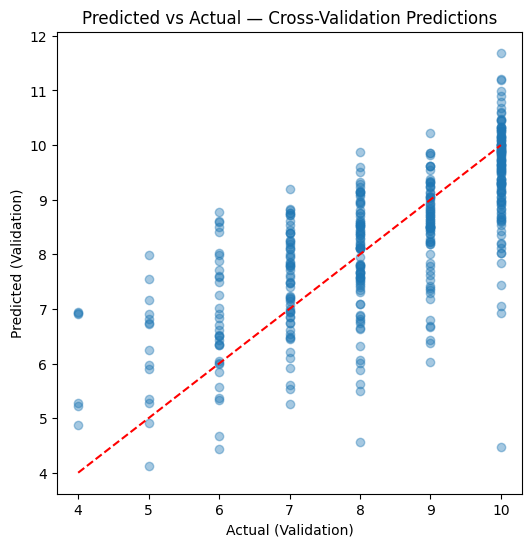

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(y_true_cv, y_pred_cv, alpha=0.4)
plt.plot([y_true_cv.min(), y_true_cv.max()],
         [y_true_cv.min(), y_true_cv.max()],
         'k--', c="red")
plt.xlabel("Actual (Validation)")
plt.ylabel("Predicted (Validation)")
plt.title("Predicted vs Actual — Cross-Validation Predictions")
plt.savefig('../../Outputs/nn_predicitons_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()


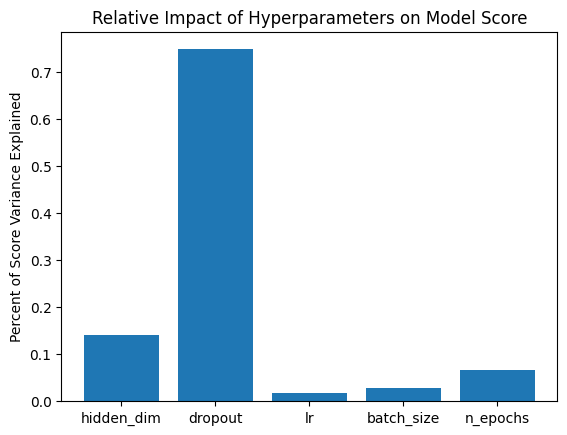

In [9]:
effects = {}
hyperparams = ["hidden_dim", "dropout", "lr", "batch_size", "n_epochs"]

for param in hyperparams:
    # variance of mean scores across choices of this param
    group_means = results_df.groupby(param)["score"].mean()
    effects[param] = np.var(group_means)

# Normalize to percent
total = sum(effects.values())
effects_norm = {k: v/total for k,v in effects.items()}

plt.bar(effects_norm.keys(), effects_norm.values())
plt.title("Relative Impact of Hyperparameters on Model Score")
plt.ylabel("Percent of Score Variance Explained")
plt.savefig('../../Outputs/nn_relative_parameter_impact.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
results_df.sort_values("avg_mse").head(5)

,hidden_dim,dropout,lr,batch_size,n_epochs,avg_mse,avg_rmse,avg_mae,avg_r2,score
25,32,0.2,0.001,16,300,0.933511,0.964780,0.764699,0.595968,0.657589
12,16,0.2,0.010,16,100,0.969369,0.980755,0.775440,0.585381,0.650234
14,16,0.2,0.010,32,100,0.984225,0.987847,0.779564,0.578396,0.646586
28,32,0.2,0.010,16,100,0.987192,0.991517,0.793940,0.571607,0.644513
30,32,0.2,0.010,32,100,0.990679,0.991865,0.788373,0.572442,0.644281


In [11]:
results_df.sort_values("avg_r2", ascending=False).head(5)

,hidden_dim,dropout,lr,batch_size,n_epochs,avg_mse,avg_rmse,avg_mae,avg_r2,score
25,32,0.2,0.001,16,300,0.933511,0.964780,0.764699,0.595968,0.657589
12,16,0.2,0.010,16,100,0.969369,0.980755,0.775440,0.585381,0.650234
14,16,0.2,0.010,32,100,0.984225,0.987847,0.779564,0.578396,0.646586
27,32,0.2,0.001,32,300,0.992706,0.993654,0.792913,0.573713,0.644343
30,32,0.2,0.010,32,100,0.990679,0.991865,0.788373,0.572442,0.644281


In [12]:
best = results_df.loc[results_df["score"].idxmax()]
print("Best Params:")
print(best)

Best Params:
hidden_dim     32.000000
dropout         0.200000
lr              0.001000
batch_size     16.000000
n_epochs      300.000000
avg_mse         0.933511
avg_rmse        0.964780
avg_mae         0.764699
avg_r2          0.595968
score           0.657589
Name: 25, dtype: float64
